# 1. Import packages

In [2]:
import numpy as np
import pandas as pd
import wbgapi as wb
import sklearn.preprocessing
import seaborn as sns
from pandas import DataFrame
from scipy.stats import shapiro
from sklearn.covariance import MinCovDet

# 2. Data Preperation
## 1.1 Import Data
Note that a special webservice 'wbgapi' is used to import data from the WorldBank, to assist the formatting process

In [3]:
# Import OECD-data from CSV-files

#Metropolitan-based data
oecd_data1 = pd.read_csv('Data/CITIES_POPULATION.csv', sep="|", header=0)
oecd_data2 = pd.read_csv('Data/CITIES_AGE.csv', sep="|", header=0)
oecd_data3 = pd.read_csv('Data/CITIES_ECONOMY.csv', sep="|", header=0)
oecd_data4 = pd.read_csv('Data/CITIES_LABOUR.csv', sep="|", header=0)
oecd_data5 = pd.read_csv('Data/CITIES_TERRITORY.csv', sep="|", header=0)
oecd_data6 = pd.read_csv('DATA/CITIES_ENVIRONMENT.csv', sep="|", header=0)

#Country-based data: this will later be translated into metropolitan data
country_codes = pd.read_excel('Extra variables\code_country.xls')
country_inlandwater = pd.read_csv('Extra variables\OECD_Country_InlandWater.csv')
country_evapotranspiration = pd.read_csv('Extra variables\OECD_Country_Evapotranspiration.csv')
country_roaddensity = pd.read_csv('Extra variables\Km of road per 100 sq. km of land area.csv')
country_area = wb.data.DataFrame('AG.LND.TOTL.K2',time=2018,labels=True)


## 1.2. OECD Data 

In [4]:
# Put all OECD-data into dataframe and append all dataframes
oecd_data_df = [oecd_data1, oecd_data2, oecd_data3, oecd_data4, oecd_data5, oecd_data6]
# Call concat method
oecd_df = pd.concat(oecd_data_df)

<b>The data is not structured in the way we want to process it (too many columns, multiple rows per sample,...). Above all, the data needs to be structured in a comprehensible format (rows=samples, columns=variables). Furthermore, a linear combination of some variables will be useful for later analysiss and merging with country-based data.

Priority is given to the primary process, such that the final structuring can be done on the bulk of the adapted data.

In [5]:
oecd_df.head()

,METRO_ID,Metropolitan areas,VAR,Variables,TIME,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,USA116,Allen,T_T,"Population, all ages, administrative data",2001,2001,PER,Persons,0,Units,NaN,NaN,365954.0,NaN,NaN
1,USA116,Allen,T_T,"Population, all ages, administrative data",2002,2002,PER,Persons,0,Units,NaN,NaN,368402.0,NaN,NaN
2,USA116,Allen,T_T,"Population, all ages, administrative data",2003,2003,PER,Persons,0,Units,NaN,NaN,371190.0,NaN,NaN
3,USA116,Allen,T_T,"Population, all ages, administrative data",2004,2004,PER,Persons,0,Units,NaN,NaN,372757.0,NaN,NaN
4,USA116,Allen,T_T,"Population, all ages, administrative data",2005,2005,PER,Persons,0,Units,NaN,NaN,375420.0,NaN,NaN


### 1.2.1 Variable creation as a linear combination of existing variabels

<b> A variable 'Construction ratio' needs to be created, in order to fetch the relative built environment

In [6]:
## CONSTRUCTION RATIO

#pick the Territory dataset, calculate the construction densiy ratio
oecd_data5_1 = oecd_data5.loc[oecd_data5['Variables']=='Urbanised area (built-up area or land for urban use in km2)']
oecd_data5_2 = oecd_data5.loc[oecd_data5['Variables']=='Metropolitan area total land area']

#oecd_data5_1 has 1336 rows, while oecd_data5_2 has 668 rows (exactly two time of the first dataset), 
#we could try to combine the two datasets by the common column "METRO_ID",

oecd_data5_improved = pd.merge(oecd_data5_1,oecd_data5_2,how='inner',on='METRO_ID')

#and then calculate the constuction density ratio = "Urbanised area" / "Metropolitan area total land area"
oecd_data5_improved['construction_ratio'] = oecd_data5_improved['Value_x'] / oecd_data5_improved['Value_y']
oecd_data5_improved.head(3)

,METRO_ID,Metropolitan areas_x,VAR_x,Variables_x,TIME_x,Year_x,Unit Code_x,Unit_x,PowerCode Code_x,PowerCode_x,...,Unit Code_y,Unit_y,PowerCode Code_y,PowerCode_y,Reference Period Code_y,Reference Period_y,Value_y,Flag Codes_y,Flags_y,construction_ratio
0,AT001,Vienna,URB_AREA,Urbanised area (built-up area or land for urba...,2000,2000,NaN,NaN,0,Units,...,NaN,NaN,0,Units,NaN,NaN,9617.0,NaN,NaN,0.077571
1,AT001,Vienna,URB_AREA,Urbanised area (built-up area or land for urba...,2014,2014,NaN,NaN,0,Units,...,NaN,NaN,0,Units,NaN,NaN,9617.0,NaN,NaN,0.089217
2,AT002,Graz,URB_AREA,Urbanised area (built-up area or land for urba...,2000,2000,NaN,NaN,0,Units,...,NaN,NaN,0,Units,NaN,NaN,3094.0,NaN,NaN,0.070459


### 1.2.2 Rename columnames

In [7]:
# create a dictionary where key = old name and value = new name
dict = {'METRO_ID': 'metroId',
        'Metropolitan areas': 'metropolitanAreas',
        'VAR': 'var',
       'Variables' : 'variables',
        'TIME' : 'time',
        'Year' : 'year',
        'Unit Code': 'unitCode',
        'Unit' : 'unit',
        'PowerCode Code' : 'powerCodeCode',
        'PowerCode': 'powerCode',
        'Reference Period Code' : 'referencePeriodCode',
        'Reference Period' : 'referencePeriod',
        'Value':'value',
        'Flag Codes' : 'flagCodes',
        'Flags': 'flags'
       }
  
# call rename () method
oecd_df.rename(columns=dict,
          inplace=True)

In [8]:
# Checking the data
print(oecd_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 586301 entries, 0 to 110607
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   metroId              586301 non-null  object 
 1   metropolitanAreas    586301 non-null  object 
 2   var                  586301 non-null  object 
 3   variables            586301 non-null  object 
 4   time                 586301 non-null  int64  
 5   year                 586301 non-null  int64  
 6   unitCode             138868 non-null  object 
 7   unit                 138868 non-null  object 
 8   powerCodeCode        586301 non-null  int64  
 9   powerCode            586301 non-null  object 
 10  referencePeriodCode  0 non-null       float64
 11  referencePeriod      0 non-null       float64
 12  value                584753 non-null  float64
 13  flagCodes            29450 non-null   object 
 14  flags                29450 non-null   object 
dtypes: float64(3), in

### 1.2.3 Add longitude and latitude to join data

<b> In order to add the possibility of visualisation, longitude and lattitude is computed for every metropolitan area

Strings that represent metropolitan areas are often different, which makes it difficult to join data from different sources. For example, "Lafayette (IN)" and "Lafayette, IN" and "Lafayette". Therefore, longitude and latitude are added as a unique identifier to join data.


Now, we add longitudes and latitudes to metropolitan areas

In [9]:
df_metropolitan = pd.read_csv('Data/CITIES_COORD.csv', header=0, sep="|", doublequote=True)
df_metropolitan

,Unnamed: 0,metropolitanAreas,longitude,latitude
0,0,Allen,-95.317021,37.888217
1,1,Warsaw,21.006725,52.231958
2,2,Kagoshima,130.547408,31.521587
3,3,Mexicali,-115.448325,32.624862
4,4,Leicester,-1.133079,52.636140
...,...,...,...,...
660,660,Cass,-94.351037,33.056086
661,661,Carmen,125.674482,7.375394
662,662,Linn,-91.603793,42.063183
663,663,Lafayette (IN),-86.890423,40.403467


<b> Merge and create temporary dataset, without country-based statistics

In [10]:
# merge the dataframes
df_oecdCoord = pd.merge(oecd_df, df_metropolitan, on="metropolitanAreas")

## 1.3 Country-based statistics (Worldbank, OECD)

<b> A first step in the process of adding national statistics as proxys for metropolitan statistics, is to built a metropolitan area-country correspondance matrix. The idea being that all national indicators can then be added to that dataframe, only then to be weighed correctly according to the relative surface of a metropolitan area in a country.

This of course assumes all variables (such as inland water, see later) to be homogeneously present over an entire country. Therefore this disaggregation process entails overestimation in some cases, underestimation in others. We consider it elligeble proxy's nonetheless.</b>

### 1.3.1 Metropolitan area - country correspondance and exception handling

<b> This process is partly automated by making use of the abbreviations utilized by OECD. Exception handling is however necessary, since some abbreviations for countries differ per dataset.

In [11]:
#OECD set of population contains the best reference in terms of number of unique cities
cities_set = set(oecd_data1['METRO_ID'])

country_dict = country_codes[['CODE','Country']].to_dict('records')
country_dict

[{'CODE': 'ABW', 'Country': 'Aruba'},
 {'CODE': 'AFG', 'Country': 'Afghanistan'},
 {'CODE': 'AFRI', 'Country': 'Africa'},
 {'CODE': 'AGO', 'Country': 'Angola'},
 {'CODE': 'AIA', 'Country': 'Anguilla'},
 {'CODE': 'ALB', 'Country': 'Albania'},
 {'CODE': 'AND', 'Country': 'Andorra'},
 {'CODE': 'ANT', 'Country': 'Netherlands Antilles'},
 {'CODE': 'ARE', 'Country': 'United Arab Emirates'},
 {'CODE': 'ARG', 'Country': 'Argentina'},
 {'CODE': 'ASIA', 'Country': 'Asia'},
 {'CODE': 'ASM', 'Country': 'American Samoa'},
 {'CODE': 'ATG', 'Country': 'Antigua and Barbuda'},
 {'CODE': 'AUS', 'Country': 'Australia'},
 {'CODE': 'AUT', 'Country': 'Austria'},
 {'CODE': 'BDI', 'Country': 'Burundi'},
 {'CODE': 'BEL', 'Country': 'Belgium'},
 {'CODE': 'BEN', 'Country': 'Benin'},
 {'CODE': 'BFA', 'Country': 'Burkina Faso'},
 {'CODE': 'BGD', 'Country': 'Bangladesh'},
 {'CODE': 'BGR', 'Country': 'Bulgaria'},
 {'CODE': 'BHR', 'Country': 'Bahrain'},
 {'CODE': 'BHS', 'Country': 'Bahamas'},
 {'CODE': 'BLZ', 'Countr

In [12]:
#function that selects first few letters of a string

def first_letters(string):
    output = ''
    for char in range(len(string)):
        if ord(str(string[char])) >= 65:
            output += str(string[char])
    return output

In [13]:
#Built dictionairy which relates every city to the country it belongs to

dict_country_city = dict.fromkeys(cities_set,0)
dict_country_city

for city in dict_country_city.keys():
    for i in range(len(country_dict)):
        if len(first_letters(city)) > 2:
            if city[:3] == country_dict[i]['CODE'][:3]:
                dict_country_city[city] = country_dict[i]['Country']
        else:
            if city[:2] == country_dict[i]['CODE'][:2]:
                dict_country_city[city] = country_dict[i]['Country']

#exception handling
for entry in dict_country_city.keys():
    if first_letters(entry) == 'UK':
        dict_country_city[entry] = 'United Kingdom'
    elif first_letters(entry) == 'CL':
        dict_country_city[entry] = 'Chile'
    elif first_letters(entry) == 'SI':
        dict_country_city[entry] = 'Slovenia'
    elif first_letters(entry) == 'LV':
        dict_country_city[entry] = 'Latvia'
    elif first_letters(entry) == 'SK':
        dict_country_city[entry] = 'Slovak Republic'
    elif first_letters(entry) == 'PT':
        dict_country_city[entry] = 'Portugal'
    elif first_letters(entry) == 'EE':
        dict_country_city[entry] = 'Estonia'
    elif first_letters(entry) == 'IE':
        dict_country_city[entry] = 'Ireland'
    elif first_letters(entry) == 'EL':
        dict_country_city[entry] = 'Greece'
    elif first_letters(entry) == 'DK':
        dict_country_city[entry] = 'Denmark'
    elif first_letters(entry) == 'CZ':
        dict_country_city[entry] = 'Czech Republic'
    elif first_letters(entry) == 'PL':
        dict_country_city[entry] = 'Poland'
    elif first_letters(entry) == 'AT':
        dict_country_city[entry] = 'Austria'
    elif first_letters(entry) == 'KOR':
        dict_country_city[entry] = 'South Korea'
    elif first_letters(entry) == 'LT':
        dict_country_city[entry] = 'South Korea'
    elif first_letters(entry) == 'BE':
        dict_country_city[entry] = 'Belgium'

        
dict_country_city

{'IT022': 'Italy',
 'USA80': 'United States',
 'JPN23': 'Japan',
 'JPN29': 'Japan',
 'AUS08': 'Australia',
 'USA100': 'United States',
 'USA108': 'United States',
 'USA131': 'United States',
 'JPN31': 'Japan',
 'ES532': 'Spain',
 'UK027': 'United Kingdom',
 'JPN48': 'Japan',
 'JPN34': 'Japan',
 'COL08': 'Colombia',
 'MEX29': 'Mexico',
 'FR018': 'France',
 'USA43': 'United States',
 'NL004': 'Netherlands',
 'UK516': 'United Kingdom',
 'USA93': 'United States',
 'USA101': 'United States',
 'USA126': 'United States',
 'USA74': 'United States',
 'KOR20': 'South Korea',
 'JPN11': 'Japan',
 'MEX43': 'Mexico',
 'COL18': 'Colombia',
 'UK019': 'United Kingdom',
 'USA67': 'United States',
 'IT009': 'Italy',
 'CAN02': 'Canada',
 'USA34': 'United States',
 'IT010': 'Italy',
 'CAN13': 'Canada',
 'USA71': 'United States',
 'FR009': 'France',
 'LT001': 'South Korea',
 'DE002': 'Germany',
 'UK010': 'United Kingdom',
 'DE012': 'Germany',
 'KOR10': 'South Korea',
 'USA62': 'United States',
 'USA22': 'Un

In [14]:
#Create dataframe for country-metro area correspondance
df_country_city = pd.DataFrame.from_dict(dict_country_city, orient='index')
df_country_city.rename(columns = {0:'Country'}, inplace = True)

### 1.3.2 Disaggregating national statistics

In [15]:
#Prepare extra variables for merging with data

#Inland water
inland_water_15 = country_inlandwater[country_inlandwater['Year']==2015]
inland_water_15 = inland_water_15[inland_water_15['MEAS']=='PCNT']
inland_water_15 = inland_water_15[['Country','Value']]

#Road density
road_density = country_roaddensity[['Country','Amount']]

#Evapotranspiration
evapotrans = country_evapotranspiration[['Country','Value']]

#merge first two
road_and_water = pd.merge(inland_water_15,road_density,how="inner",on='Country')
road_water_evapo = pd.merge(road_and_water,evapotrans,how="inner",on='Country')

#merge with main dataframe
df_country_city_ext = df_country_city.reset_index().merge(road_water_evapo, how="left",on='Country').set_index('index')
df_country_city_ext.rename(columns = {'Value_x':'CNTRY_INLAND_WATER','Amount':'CNTRY_ROAD_DENS','Value_y':'EVAPOTRANS'}, inplace = True)
df_country_city_ext

,Country,CNTRY_INLAND_WATER,CNTRY_ROAD_DENS,EVAPOTRANS
index,,,,
IT022,Italy,1.007836,162,147.3654
USA80,United States,2.360209,68,3980.0000
JPN23,Japan,1.477841,316,230.0000
JPN29,Japan,1.477841,316,230.0000
AUS08,Australia,0.164075,11,3138.3360
...,...,...,...,...
MEX32,Mexico,1.405378,18.33,1046.5920
UK025,United Kingdom,1.421405,172.41,127.2895
DE032,Germany,1.241050,180.51,161.0000


In [16]:
#Now we add relative territory of the city

cities_surface = oecd_data5[oecd_data5['VAR']=='SURF']
cities_surface = cities_surface[['METRO_ID','Value']]
cities_surface.rename(columns = {'METRO_ID':'index'}, inplace = True)
cities_surface

country_area = country_area[['Country','AG.LND.TOTL.K2']]

#merge both with the main dataframe
merged_data = df_country_city_ext.reset_index().merge(country_area, how="left",on='Country').set_index('index')
merged_data = merged_data.reset_index().merge(cities_surface, how="left",on='index').set_index('index')

merged_data.rename(columns = {'AG.LND.TOTL.K2':'CNTRY_TOT_AREA','Value':'CITY_TOT_SURF'}, inplace = True)
merged_data

#Calculate relative city surface
merged_data['CITY_REL_SURF'] = (merged_data['CITY_TOT_SURF'] / merged_data['CNTRY_TOT_AREA'])

In [17]:
#Use relative city surface to weigh and disaggregate national statistics
merged_data['CITY_REL_ROADS'] = (merged_data['CNTRY_ROAD_DENS'].astype(float) * merged_data['CITY_REL_SURF'])
merged_data['CITY_REL_WATER'] = (merged_data['CNTRY_INLAND_WATER'] * merged_data['CITY_REL_SURF'])
merged_data['CITY_EVAPOTRANS'] = (merged_data['EVAPOTRANS'] * merged_data['CITY_REL_SURF'])

#Prepare for merge with city-based statistics
merged_data.rename(index = {'index':'metroId'}, inplace = True)
merged_data

,Country,CNTRY_INLAND_WATER,CNTRY_ROAD_DENS,EVAPOTRANS,CNTRY_TOT_AREA,CITY_TOT_SURF,CITY_REL_SURF,CITY_REL_ROADS,CITY_REL_WATER,CITY_EVAPOTRANS
index,,,,,,,,,,
IT022,Italy,1.007836,162,147.3654,297730.0,1053.0,0.003537,0.572955,0.003564,0.521196
USA80,United States,2.360209,68,3980.0000,9147420.0,5271.0,0.000576,0.039184,0.001360,2.293388
JPN23,Japan,1.477841,316,230.0000,364500.0,1116.0,0.003062,0.967506,0.004525,0.704198
JPN29,Japan,1.477841,316,230.0000,364500.0,1620.0,0.004444,1.404444,0.006568,1.022222
AUS08,Australia,0.164075,11,3138.3360,7692020.0,1581.0,0.000206,0.002261,0.000034,0.645046
...,...,...,...,...,...,...,...,...,...,...
MEX32,Mexico,1.405378,18.33,1046.5920,1943950.0,1603.0,0.000825,0.015115,0.001159,0.863030
UK025,United Kingdom,1.421405,172.41,127.2895,241930.0,813.0,0.003360,0.579380,0.004777,0.427753
DE032,Germany,1.241050,180.51,161.0000,349380.0,2853.0,0.008166,1.474026,0.010134,1.314709


## 1.4 Transpose dataset, merge datasets

<b> Now, we're going to transform the matrix such that on the rows we find countries, whereas on the columns we find variables.
In principle, such matrix could be built for every year. A first step is to delete all metadata related variables. Next, only the useful variables are kept. A final step is to eliminate the time dimension.

In [18]:
#first get rid of all metadata-related columns
df_oecd_col_red = df_oecdCoord[['metroId','metropolitanAreas','latitude','longitude','var','variables','year','value']]

#first test some things on 1 year
df_oecd_col_red_14 = df_oecd_col_red[df_oecd_col_red['year']==2014]
#df_oecd_col_red_14.head()

#group by metropolitanAreas
df_total_14 = df_oecd_col_red_14[['metroId','metropolitanAreas','latitude','longitude','var','value']]

df_total_14 = df_total_14.pivot_table(index=['metroId','metropolitanAreas','latitude','longitude'], 
                    columns=['var',], 
                    values='value', 
                    aggfunc='mean')
df_total_14

,,,var,CDD,ELD_DEP_RA,EMP_IND_TOTAL,EMP_RA_15_64,EMP_RA_15_64_GR_2001,EMP_RA_15_64_GR_2007,EMP_RA_15_MAX,EMP_RA_15_MAX_GR_2001,EMP_RA_15_MAX_GR_2007,EMP_Y15_64,...,UNEM_RA_15_MAX,UNEM_Y15_64,UNEM_Y15_64_SH_NAT,UNEM_Y15_MAX,UNEM_Y15_MAX_SH_NAT,URB_AREA,URB_AREA_CORE,URB_AREA_HINTER,URB_AREA_PC,YOU_DEP_RA
metroId,metropolitanAreas,latitude,longitude,,,,,,,,,,,,,,,,,,,,,
AT001,Vienna,48.208354,16.372504,23.0,26.2,1408986.0,66.1,96.7,101.0,54.4,96.0,96.8,1263282.0,...,7.6,116316.0,47.6,107269.0,43.8,858.0,222.0,636.0,303.0,21.1
AT002,Graz,47.070868,15.438279,2.0,25.8,337576.0,65.4,106.5,92.6,54.3,97.3,93.9,281151.0,...,4.8,15631.0,6.4,14906.0,6.1,248.0,59.0,189.0,393.0,19.8
AT003,Linz,48.305908,14.286198,2.0,25.9,341180.0,71.3,102.7,100.4,60.7,104.9,99.6,300108.0,...,4.2,NaN,NaN,13948.0,5.7,189.0,43.0,146.0,303.0,22.1
AT004,Salzburg,47.798135,13.046481,1.0,26.2,211410.0,73.5,104.0,103.9,58.1,97.0,92.7,178429.0,...,3.6,6654.0,2.7,6615.0,2.7,97.0,28.0,69.0,268.0,21.8
AT005,Innsbruck,47.265430,11.392768,0.0,25.1,189869.0,69.1,103.0,97.5,58.7,103.9,94.8,158927.0,...,3.4,NaN,NaN,5987.0,2.4,108.0,19.0,88.0,322.0,20.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USA95,Ingham,42.586050,-84.380084,15.0,19.5,NaN,NaN,NaN,NaN,58.1,87.9,93.2,NaN,...,5.9,NaN,NaN,14267.0,0.1,271.0,141.0,130.0,578.0,25.0
USA96,Montgomery (AL),33.810124,-86.809849,550.0,20.9,245777.0,NaN,NaN,NaN,43.8,94.3,95.2,NaN,...,6.6,NaN,NaN,11268.0,0.1,246.0,154.0,92.0,528.0,28.6
USA97,Knox,33.587139,-99.707362,141.0,21.5,NaN,NaN,NaN,NaN,52.8,87.3,85.9,NaN,...,6.2,NaN,NaN,13304.0,0.1,253.0,242.0,11.0,532.0,26.4


<b> Once metadata is cleared, and the dataset is pivotted, it is time to perform a preliminary QUALITATIVE variable selection, since the OECD-data contains many variables already that are highly unlikely to contribute to the model given the scope of this research (e.g. vulnerability to pollution (PWM_EX_CORE) is taken in stead of specific vulnerability to specific pollution). Preference is furthermore given to aggregate and relative variables (e.g. population density, or share of elderly in stead of absolute numbers). </b>

In [19]:
#Now we only select the useful variables: i.e. aggregate variables, relative variables, ...
df_selection_14 = df_total_14[['CDD','URB_AREA','URB_AREA_CORE',
                               'URB_AREA_HINTER','FRAGMENTATION',
                               'GDP_PC_REAL_PPP','PARTIC_RA_15_64','POP_DEN',
                              'POP_TOT_GI','PWM_EX_CORE','T_Y0_14_SH_NAT',
                               'T_Y15_64_SH_NAT','T_Y65_MAX_SH_NAT'
                              ]]
df_selection_14


,,,var,CDD,URB_AREA,URB_AREA_CORE,URB_AREA_HINTER,FRAGMENTATION,GDP_PC_REAL_PPP,PARTIC_RA_15_64,POP_DEN,POP_TOT_GI,PWM_EX_CORE,T_Y0_14_SH_NAT,T_Y15_64_SH_NAT,T_Y65_MAX_SH_NAT
metroId,metropolitanAreas,latitude,longitude,,,,,,,,,,,,,
AT001,Vienna,48.208354,16.372504,23.0,858.0,222.0,636.0,12.4,53992.0,72.2,293.0,112.5,14.9,33.1,33.3,32.2
AT002,Graz,47.070868,15.438279,2.0,248.0,59.0,189.0,16.3,50492.0,69.8,202.0,110.8,17.7,7.0,7.5,7.1
AT003,Linz,48.305908,14.286198,2.0,189.0,43.0,146.0,22.6,53792.0,74.8,175.0,105.3,15.3,7.6,7.3,7.0
AT004,Salzburg,47.798135,13.046481,1.0,97.0,28.0,69.0,15.9,62784.0,76.3,232.0,105.5,12.3,4.3,4.2,4.1
AT005,Innsbruck,47.265430,11.392768,0.0,108.0,19.0,88.0,23.0,53602.0,71.7,132.0,110.4,12.6,3.9,4.0,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USA95,Ingham,42.586050,-84.380084,15.0,271.0,141.0,130.0,7.2,42603.0,NaN,106.0,104.3,8.2,0.1,0.2,0.1
USA96,Montgomery (AL),33.810124,-86.809849,550.0,246.0,154.0,92.0,9.3,41655.0,NaN,33.0,105.4,10.6,0.1,0.1,0.1
USA97,Knox,33.587139,-99.707362,141.0,253.0,242.0,11.0,1.3,49942.0,NaN,233.0,115.5,9.1,0.1,0.1,0.1


<b> We now add some variables seperately, notably: the construction data from 1.2.2, and the tree share cover from the territory dataset (OECD). It is noted that the 'Tree share cover' data is from 2015, whereas the general dataset contains data from 2014. Although tree cover data is available from 2004, such that an interpolation would be possible, we opted not to do so, since interpolation or extrapolation entails callibrating a growth model (linear, logarithmic, exponential?). Since such computations would induce more errors.</b>

In [20]:
#Next we add (1) construction ratio and (2) Tree cover manually as variables

#Construction_data
construction_ratio_14 = oecd_data5_improved[oecd_data5_improved['Year_x']==2014]
construction_ratio_14 = construction_ratio_14[['METRO_ID','construction_ratio']]

#Tree_cover
tree_cover = oecd_data6[oecd_data6['VAR']=='TREECOVER_SHARE_CORE']
tree_cover = tree_cover[tree_cover['Year']==2015]
tree_cover = tree_cover[['METRO_ID','Value']]

tree_and_construction = pd.merge(construction_ratio_14,tree_cover,how='inner',on='METRO_ID')
tree_and_construction = tree_and_construction.rename(columns = {'METRO_ID':'metroId','construction_ratio': 'CONSTR_RAT', 'Value': 'TREECOVER_SHARE_CORE'}, inplace = False)

#Merge with main dataset

df_extended_14 = df_selection_14.reset_index().merge(tree_and_construction, how='left',on='metroId')
df_extended_14


,metroId,metropolitanAreas,latitude,longitude,CDD,URB_AREA,URB_AREA_CORE,URB_AREA_HINTER,FRAGMENTATION,GDP_PC_REAL_PPP,PARTIC_RA_15_64,POP_DEN,POP_TOT_GI,PWM_EX_CORE,T_Y0_14_SH_NAT,T_Y15_64_SH_NAT,T_Y65_MAX_SH_NAT,CONSTR_RAT,TREECOVER_SHARE_CORE
0,AT001,Vienna,48.208354,16.372504,23.0,858.0,222.0,636.0,12.4,53992.0,72.2,293.0,112.5,14.9,33.1,33.3,32.2,0.089217,22.1
1,AT002,Graz,47.070868,15.438279,2.0,248.0,59.0,189.0,16.3,50492.0,69.8,202.0,110.8,17.7,7.0,7.5,7.1,0.080155,32.9
2,AT003,Linz,48.305908,14.286198,2.0,189.0,43.0,146.0,22.6,53792.0,74.8,175.0,105.3,15.3,7.6,7.3,7.0,0.053209,15.6
3,AT004,Salzburg,47.798135,13.046481,1.0,97.0,28.0,69.0,15.9,62784.0,76.3,232.0,105.5,12.3,4.3,4.2,4.1,0.062743,18.8
4,AT005,Innsbruck,47.265430,11.392768,0.0,108.0,19.0,88.0,23.0,53602.0,71.7,132.0,110.4,12.6,3.9,4.0,3.7,0.042671,56.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,USA95,Ingham,42.586050,-84.380084,15.0,271.0,141.0,130.0,7.2,42603.0,NaN,106.0,104.3,8.2,0.1,0.2,0.1,0.060995,10.6
663,USA96,Montgomery (AL),33.810124,-86.809849,550.0,246.0,154.0,92.0,9.3,41655.0,NaN,33.0,105.4,10.6,0.1,0.1,0.1,0.017839,48.7
664,USA97,Knox,33.587139,-99.707362,141.0,253.0,242.0,11.0,1.3,49942.0,NaN,233.0,115.5,9.1,0.1,0.1,0.1,0.126122,27.8
665,USA98,Greenville,34.851354,-82.398488,221.0,251.0,251.0,NaN,4.4,53205.0,NaN,233.0,124.8,8.9,0.2,0.2,0.1,0.121667,46.6


Next, the country-based statistics are to be added to the dataset

In [21]:
#create a selection of only the variables to be merged
national_data = merged_data[['CITY_REL_ROADS','CITY_REL_WATER','CITY_EVAPOTRANS']]
national_data.reset_index(level=0, inplace=True)
national_data = national_data.rename(columns={'index':'metroId'})
national_data

,metroId,CITY_REL_ROADS,CITY_REL_WATER,CITY_EVAPOTRANS
0,IT022,0.572955,0.003564,0.521196
1,USA80,0.039184,0.001360,2.293388
2,JPN23,0.967506,0.004525,0.704198
3,JPN29,1.404444,0.006568,1.022222
4,AUS08,0.002261,0.000034,0.645046
...,...,...,...,...
663,MEX32,0.015115,0.001159,0.863030
664,UK025,0.579380,0.004777,0.427753
665,DE032,1.474026,0.010134,1.314709
666,DE079,0.549724,0.003779,0.490309


In [22]:
complete_data = df_extended_14.reset_index().merge(national_data, how='left',on='metroId')
complete_data

,index,metroId,metropolitanAreas,latitude,longitude,CDD,URB_AREA,URB_AREA_CORE,URB_AREA_HINTER,FRAGMENTATION,...,POP_TOT_GI,PWM_EX_CORE,T_Y0_14_SH_NAT,T_Y15_64_SH_NAT,T_Y65_MAX_SH_NAT,CONSTR_RAT,TREECOVER_SHARE_CORE,CITY_REL_ROADS,CITY_REL_WATER,CITY_EVAPOTRANS
0,0,AT001,Vienna,48.208354,16.372504,23.0,858.0,222.0,636.0,12.4,...,112.5,14.9,33.1,33.3,32.2,0.089217,22.1,14.896327,0.095709,5.022936
1,1,AT002,Graz,47.070868,15.438279,2.0,248.0,59.0,189.0,16.3,...,110.8,17.7,7.0,7.5,7.1,0.080155,32.9,4.792476,0.030792,1.615989
2,2,AT003,Linz,48.305908,14.286198,2.0,189.0,43.0,146.0,22.6,...,105.3,15.3,7.6,7.3,7.0,0.053209,15.6,5.501898,0.035350,1.855201
3,3,AT004,Salzburg,47.798135,13.046481,1.0,97.0,28.0,69.0,15.9,...,105.5,12.3,4.3,4.2,4.1,0.062743,18.8,2.394689,0.015386,0.807472
4,4,AT005,Innsbruck,47.265430,11.392768,0.0,108.0,19.0,88.0,23.0,...,110.4,12.6,3.9,4.0,3.7,0.042671,56.4,3.920412,0.025189,1.321935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,662,USA95,Ingham,42.586050,-84.380084,15.0,271.0,141.0,130.0,7.2,...,104.3,8.2,0.1,0.2,0.1,0.060995,10.6,0.033028,0.001146,1.933129
663,663,USA96,Montgomery (AL),33.810124,-86.809849,550.0,246.0,154.0,92.0,9.3,...,105.4,10.6,0.1,0.1,0.1,0.017839,48.7,0.102512,0.003558,5.999965
664,664,USA97,Knox,33.587139,-99.707362,141.0,253.0,242.0,11.0,1.3,...,115.5,9.1,0.1,0.1,0.1,0.126122,27.8,0.014912,0.000518,0.872801
665,665,USA98,Greenville,34.851354,-82.398488,221.0,251.0,251.0,NaN,4.4,...,124.8,8.9,0.2,0.2,0.1,0.121667,46.6,0.015336,0.000532,0.897602


# 1.5 Data Cleaning

In [23]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667 entries, 0 to 666
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 667 non-null    int64  
 1   metroId               667 non-null    object 
 2   metropolitanAreas     667 non-null    object 
 3   latitude              667 non-null    float64
 4   longitude             667 non-null    float64
 5   CDD                   663 non-null    float64
 6   URB_AREA              667 non-null    float64
 7   URB_AREA_CORE         667 non-null    float64
 8   URB_AREA_HINTER       530 non-null    float64
 9   FRAGMENTATION         634 non-null    float64
 10  GDP_PC_REAL_PPP       489 non-null    float64
 11  PARTIC_RA_15_64       235 non-null    float64
 12  POP_DEN               667 non-null    float64
 13  POP_TOT_GI            516 non-null    float64
 14  PWM_EX_CORE           666 non-null    float64
 15  T_Y0_14_SH_NAT        6

In [24]:
complete_data.describe()

,index,latitude,longitude,CDD,URB_AREA,URB_AREA_CORE,URB_AREA_HINTER,FRAGMENTATION,GDP_PC_REAL_PPP,PARTIC_RA_15_64,...,POP_TOT_GI,PWM_EX_CORE,T_Y0_14_SH_NAT,T_Y15_64_SH_NAT,T_Y65_MAX_SH_NAT,CONSTR_RAT,TREECOVER_SHARE_CORE,CITY_REL_ROADS,CITY_REL_WATER,CITY_EVAPOTRANS
count,667.000000,667.000000,667.000000,663.000000,667.000000,667.000000,530.000000,634.000000,489.000000,235.000000,...,516.000000,666.000000,630.000000,630.000000,630.000000,667.000000,667.000000,585.000000,585.000000,585.000000
mean,333.000000,38.496694,-15.646675,188.291101,325.499250,221.775112,130.505660,6.975710,44307.977505,73.219574,...,109.734496,13.777027,2.796667,2.829048,2.642698,0.105241,25.651574,1.893792,0.017067,2.171350
std,192.690598,16.925330,73.932956,362.390879,620.411322,521.515193,178.071822,11.517911,14896.912757,6.604178,...,12.508747,6.256057,7.173308,7.247996,6.776031,0.094659,22.301001,10.059930,0.059081,3.410132
min,0.000000,-41.471812,-123.113953,0.000000,2.000000,2.000000,0.000000,0.100000,7580.000000,48.000000,...,81.200000,4.500000,0.100000,0.100000,0.100000,0.000126,0.000000,0.000598,0.000009,0.072608
25%,166.500000,34.180688,-84.451362,5.000000,85.000000,38.000000,36.000000,0.800000,35018.000000,71.000000,...,101.475000,9.300000,0.300000,0.300000,0.300000,0.039818,6.650000,0.049539,0.001379,0.637447
50%,333.000000,41.875562,-0.875661,28.000000,147.000000,79.000000,74.000000,3.400000,42329.000000,74.300000,...,107.950000,12.200000,0.700000,0.700000,0.700000,0.076712,19.500000,0.356419,0.003536,1.131205
75%,499.500000,50.037991,11.403786,168.000000,290.000000,187.000000,139.750000,7.500000,53602.000000,77.250000,...,115.750000,15.975000,1.800000,1.875000,1.800000,0.141490,39.650000,1.033394,0.007850,2.265106
max,666.000000,65.011873,166.649217,2391.000000,6718.000000,6718.000000,1358.000000,107.800000,121011.000000,92.700000,...,185.900000,36.400000,99.700000,100.400000,100.700000,0.693385,92.200000,214.400000,0.849712,41.636015


In [25]:
complete_data.isna().sum()

index                     0
metroId                   0
metropolitanAreas         0
latitude                  0
longitude                 0
CDD                       4
URB_AREA                  0
URB_AREA_CORE             0
URB_AREA_HINTER         137
FRAGMENTATION            33
GDP_PC_REAL_PPP         178
PARTIC_RA_15_64         432
POP_DEN                   0
POP_TOT_GI              151
PWM_EX_CORE               1
T_Y0_14_SH_NAT           37
T_Y15_64_SH_NAT          37
T_Y65_MAX_SH_NAT         37
CONSTR_RAT                0
TREECOVER_SHARE_CORE      0
CITY_REL_ROADS           82
CITY_REL_WATER           82
CITY_EVAPOTRANS          82
dtype: int64

<b> Samples for which we don't have any data on the Cooling Degree Days, are to be dropped anyway since they will not be of any use as observations for the the dependent variable. </b>

In [26]:
complete_data.dropna(subset=['CDD'],inplace=True)
# drop values that have missing data for cooling days
complete_data.head(10)

,index,metroId,metropolitanAreas,latitude,longitude,CDD,URB_AREA,URB_AREA_CORE,URB_AREA_HINTER,FRAGMENTATION,...,POP_TOT_GI,PWM_EX_CORE,T_Y0_14_SH_NAT,T_Y15_64_SH_NAT,T_Y65_MAX_SH_NAT,CONSTR_RAT,TREECOVER_SHARE_CORE,CITY_REL_ROADS,CITY_REL_WATER,CITY_EVAPOTRANS
0,0,AT001,Vienna,48.208354,16.372504,23.0,858.0,222.0,636.0,12.4,...,112.5,14.9,33.1,33.3,32.2,0.089217,22.1,14.896327,0.095709,5.022936
1,1,AT002,Graz,47.070868,15.438279,2.0,248.0,59.0,189.0,16.3,...,110.8,17.7,7.0,7.5,7.1,0.080155,32.9,4.792476,0.030792,1.615989
2,2,AT003,Linz,48.305908,14.286198,2.0,189.0,43.0,146.0,22.6,...,105.3,15.3,7.6,7.3,7.0,0.053209,15.6,5.501898,0.035350,1.855201
3,3,AT004,Salzburg,47.798135,13.046481,1.0,97.0,28.0,69.0,15.9,...,105.5,12.3,4.3,4.2,4.1,0.062743,18.8,2.394689,0.015386,0.807472
4,4,AT005,Innsbruck,47.265430,11.392768,0.0,108.0,19.0,88.0,23.0,...,110.4,12.6,3.9,4.0,3.7,0.042671,56.4,3.920412,0.025189,1.321935
5,5,AT006,Klagenfurt,46.622816,14.307960,0.0,95.0,29.0,66.0,16.7,...,101.0,13.7,2.8,2.9,3.2,0.040237,43.5,3.657089,0.023497,1.233145
6,6,AUS01,Greater Sydney,51.548781,0.133342,51.0,1582.0,1190.0,392.0,6.4,...,118.0,7.2,20.5,21.1,18.7,0.127581,22.5,0.017733,0.000264,5.059187
7,7,AUS02,Greater Melbourne,-38.064836,145.226901,83.0,1944.0,1572.0,372.0,6.9,...,127.9,8.0,18.4,19.6,17.5,0.194264,4.6,0.014311,0.000213,4.082845
8,8,AUS03,Greater Brisbane,51.560063,-0.012622,147.0,1347.0,741.0,605.0,10.3,...,134.7,5.9,10.2,9.9,8.2,0.084786,18.3,0.022719,0.000339,6.481879
9,9,AUS04,Greater Perth,51.532167,0.088256,233.0,1089.0,696.0,393.0,8.8,...,135.6,7.9,8.4,8.6,7.4,0.169178,8.6,0.009205,0.000137,2.626289


In [27]:
# We further reduce the dataset extent by only allowing columns to exhibit at least 80% real values.
complete_data.dropna(thresh=0.8*len(complete_data),axis=1,inplace=True)

#replace missing values with mean of the specific column
complete_data_1 = complete_data.iloc[:,5:].where(pd.notna(complete_data), complete_data.mean(), axis="columns")


In [28]:
complete_data_1.isna().sum()

CDD                     0
URB_AREA                0
URB_AREA_CORE           0
FRAGMENTATION           0
POP_DEN                 0
PWM_EX_CORE             0
T_Y0_14_SH_NAT          0
T_Y15_64_SH_NAT         0
T_Y65_MAX_SH_NAT        0
CONSTR_RAT              0
TREECOVER_SHARE_CORE    0
CITY_REL_ROADS          0
CITY_REL_WATER          0
CITY_EVAPOTRANS         0
dtype: int64

In [29]:
complete_data_1.insert(0, 'metroId', complete_data['metroId'])
complete_data_1.insert(1,'metropolitanAreas',complete_data['metropolitanAreas'])
complete_data_1.insert(2,'lat',complete_data['latitude'])
complete_data_1.insert(3,'long',complete_data['longitude'])

complete_data_1.head()

,metroId,metropolitanAreas,lat,long,CDD,URB_AREA,URB_AREA_CORE,FRAGMENTATION,POP_DEN,PWM_EX_CORE,T_Y0_14_SH_NAT,T_Y15_64_SH_NAT,T_Y65_MAX_SH_NAT,CONSTR_RAT,TREECOVER_SHARE_CORE,CITY_REL_ROADS,CITY_REL_WATER,CITY_EVAPOTRANS
0,AT001,Vienna,48.208354,16.372504,23.0,858.0,222.0,12.4,293.0,14.9,33.1,33.3,32.2,0.089217,22.1,14.896327,0.095709,5.022936
1,AT002,Graz,47.070868,15.438279,2.0,248.0,59.0,16.3,202.0,17.7,7.0,7.5,7.1,0.080155,32.9,4.792476,0.030792,1.615989
2,AT003,Linz,48.305908,14.286198,2.0,189.0,43.0,22.6,175.0,15.3,7.6,7.3,7.0,0.053209,15.6,5.501898,0.035350,1.855201
3,AT004,Salzburg,47.798135,13.046481,1.0,97.0,28.0,15.9,232.0,12.3,4.3,4.2,4.1,0.062743,18.8,2.394689,0.015386,0.807472
4,AT005,Innsbruck,47.265430,11.392768,0.0,108.0,19.0,23.0,132.0,12.6,3.9,4.0,3.7,0.042671,56.4,3.920412,0.025189,1.321935


In [30]:
complete_data_1.to_csv('MainData_NotScaled.csv', header="True", sep="|", doublequote=True)

## 1.6 Outlier detection & removal

In [31]:
complete_data_1.describe()

,lat,long,CDD,URB_AREA,URB_AREA_CORE,FRAGMENTATION,POP_DEN,PWM_EX_CORE,T_Y0_14_SH_NAT,T_Y15_64_SH_NAT,T_Y65_MAX_SH_NAT,CONSTR_RAT,TREECOVER_SHARE_CORE,CITY_REL_ROADS,CITY_REL_WATER,CITY_EVAPOTRANS
count,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000,663.000000
mean,38.577194,-15.756992,188.291101,326.695324,222.788839,6.987322,456.230769,13.789124,2.806380,2.839553,2.652951,0.104694,25.658069,1.904388,0.017174,2.182670
std,16.920886,73.899266,362.390879,622.028256,522.902237,11.260553,538.592851,6.265399,6.990844,7.063458,6.603398,0.092845,22.320360,9.447942,0.055478,3.200346
min,-41.471812,-123.113953,0.000000,2.000000,2.000000,0.100000,9.000000,4.500000,0.100000,0.100000,0.100000,0.000126,0.000000,0.000598,0.000009,0.072608
25%,34.367082,-84.537328,5.000000,85.500000,38.000000,0.900000,143.000000,9.300000,0.300000,0.300000,0.300000,0.039128,6.650000,0.068545,0.001661,0.696802
50%,41.893320,-0.875661,28.000000,147.000000,79.000000,3.700000,287.000000,12.200000,0.700000,0.700000,0.700000,0.076712,19.500000,0.529452,0.004284,1.350653
75%,50.066016,11.403786,168.000000,290.000000,187.500000,7.150000,558.500000,16.050000,2.400000,2.400000,2.400000,0.141490,39.650000,1.771937,0.014897,2.182670
max,65.011873,166.649217,2391.000000,6718.000000,6718.000000,107.800000,4304.000000,36.400000,99.700000,100.400000,100.700000,0.693385,92.200000,214.400000,0.849712,41.636015


In [32]:
shapiro(complete_data_1['CDD'])

ShapiroResult(statistic=0.5751733779907227, pvalue=3.010147167836483e-37)

<b> As the shapiro test yields a p-value smaller than 0.05, the null hypothesis that the variable CDD is normally distributed is rejected. Therefore, when detecting outliers, we should note that any method that asumes normal distribution (such as using  Z-scores) is to be disregarded.</b>

<AxesSubplot:xlabel='CDD', ylabel='Count'>

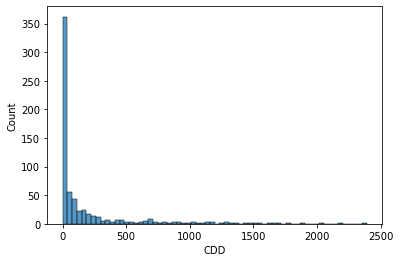

In [33]:
sns.histplot(complete_data_1['CDD'])
#axes-level function for histograms

<b> The Minimum Covariance Determinant covariance estimator is to be applied on Gaussian-distributed data,
but could still be relevant on data drawn from a unimodal, symmetric distribution. 
It is not meant to be used with multi-modal data (the algorithm used to fit a MinCovDet object is likely to fail in such a case). One should consider projection pursuit methods to deal with multi-modal datasets. </b>


<AxesSubplot:xlabel='CDD', ylabel='Count'>

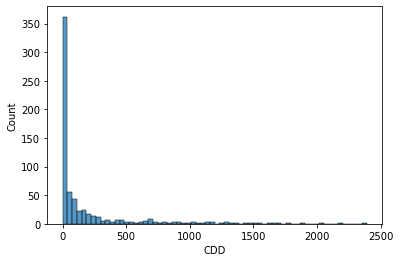

In [34]:
sns.histplot(complete_data_1['CDD'])
#axes-level function for histograms
#unimodal

In [35]:
dist_test_mincov = MinCovDet(random_state=0).fit(complete_data_1.loc[:,'CDD':'CITY_REL_WATER']).mahalanobis(complete_data_1.loc[:,'CDD':'CITY_REL_WATER'])

In [36]:
from scipy.stats import chi2
crit_distance = chi2.ppf((1-0.01), df=complete_data_1.shape[1] - 1)
#p-value that is less than .001 is considered to be an outlier

In [37]:
#idx = dist_test_mincov>crit_distance
crit_distance


33.40866360500461

In [80]:
complete_data_mahalonobis = complete_data_1.copy()

In [81]:
complete_data_mahalonobis['mahalanobis'] = dist_test_mincov

In [82]:
complete_data_mahalonobis

,metroId,metropolitanAreas,lat,long,CDD,URB_AREA,URB_AREA_CORE,FRAGMENTATION,POP_DEN,PWM_EX_CORE,T_Y0_14_SH_NAT,T_Y15_64_SH_NAT,T_Y65_MAX_SH_NAT,CONSTR_RAT,TREECOVER_SHARE_CORE,CITY_REL_ROADS,CITY_REL_WATER,CITY_EVAPOTRANS,mahalanobis
0,AT001,Vienna,48.208354,16.372504,23.0,858.0,222.0,12.4,293.0,14.9,33.1,33.3,32.2,0.089217,22.1,14.896327,0.095709,5.022936,2605.741485
1,AT002,Graz,47.070868,15.438279,2.0,248.0,59.0,16.3,202.0,17.7,7.0,7.5,7.1,0.080155,32.9,4.792476,0.030792,1.615989,197.078341
2,AT003,Linz,48.305908,14.286198,2.0,189.0,43.0,22.6,175.0,15.3,7.6,7.3,7.0,0.053209,15.6,5.501898,0.035350,1.855201,171.378558
3,AT004,Salzburg,47.798135,13.046481,1.0,97.0,28.0,15.9,232.0,12.3,4.3,4.2,4.1,0.062743,18.8,2.394689,0.015386,0.807472,38.905248
4,AT005,Innsbruck,47.265430,11.392768,0.0,108.0,19.0,23.0,132.0,12.6,3.9,4.0,3.7,0.042671,56.4,3.920412,0.025189,1.321935,63.529648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,USA95,Ingham,42.586050,-84.380084,15.0,271.0,141.0,7.2,106.0,8.2,0.1,0.2,0.1,0.060995,10.6,0.033028,0.001146,1.933129,10.794761
663,USA96,Montgomery (AL),33.810124,-86.809849,550.0,246.0,154.0,9.3,33.0,10.6,0.1,0.1,0.1,0.017839,48.7,0.102512,0.003558,5.999965,6.982662
664,USA97,Knox,33.587139,-99.707362,141.0,253.0,242.0,1.3,233.0,9.1,0.1,0.1,0.1,0.126122,27.8,0.014912,0.000518,0.872801,5.308388
665,USA98,Greenville,34.851354,-82.398488,221.0,251.0,251.0,4.4,233.0,8.9,0.2,0.2,0.1,0.121667,46.6,0.015336,0.000532,0.897602,6.513207


In [83]:
idx = dist_test_mincov>crit_distance
np.sum(idx==True)

251

<b> Above represents the number of ouliers removed based on Mahalanobis Distance </b>

<AxesSubplot:xlabel='CDD', ylabel='Count'>

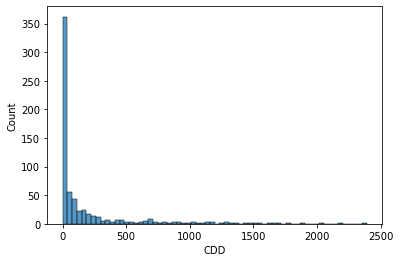

In [84]:
sns.histplot(complete_data_mahalonobis['CDD'])

In [85]:
complete_data_mahalonobis = complete_data_mahalonobis[complete_data_mahalonobis['mahalanobis'] < crit_distance]
complete_data_mahalonobis.loc[:,'metroId':'CITY_EVAPOTRANS'].to_csv('MainData_NotScaled_OutliersRemoved.csv', header="True", sep="|", doublequote=True) 